# Image Processing - Assignment 2
### Zerntev Alexandros (not an official member of DSIT master's program yet, so please keep the mark for the next year)

## Introduction
The assignment consists of two parts. Part one to find the angle of the billiard cue with respect to x axis and Part two is to combine image1 and image2 to generate image 3. 
## Part One
For this part Hough transform has been used. Since the billiard cue is the only object with straight lines, applying Hough lines with only one max voted line and 200 at least votes as parameters, has found the needed line.

The found line is the green line of below image and not the line with respect to x axis since hough lines returns a \[angle - distance\] with respect to point (0,0) representation of a line. 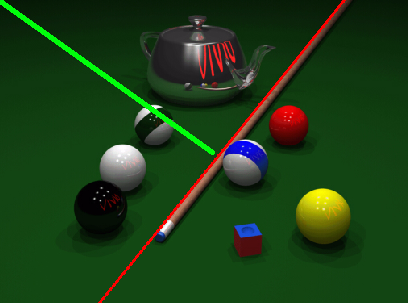

The angle between the line of the billiard cue and the x axis can be found by this formula: (theta+90)%180 (this depends on the range parameters set in the HoughLines function, in this assignment the range \[1,180\] and not \[1,360\] was used, because of the symmetry of the needed angle)

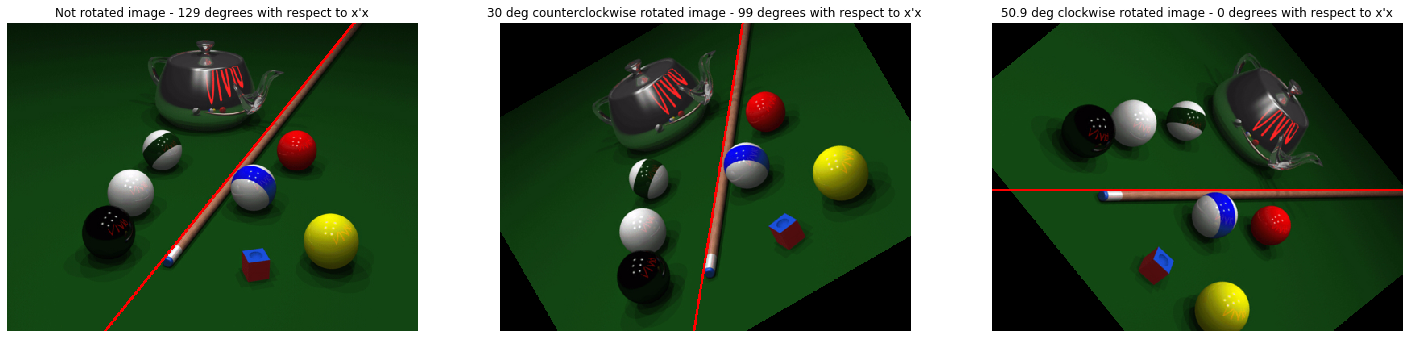

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import copy
from scipy import ndimage

# a function that draws lines on the image
def add_lines_to_image(img, lines):
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)


# Read the images
img1 = cv2.imread('image1.png')

### Image 1 rotated by 0 deg
# copying the initial image
im10 = copy.copy(img1)
# converting to grayscale
gray10 = cv2.cvtColor(im10,cv2.COLOR_BGR2GRAY)
# finding the edges
edges10 = cv2.Canny(gray10,50,150,apertureSize = 3)
# finding the lines
lines10 = cv2.HoughLines(edges10,1,np.pi/180,200)
# adding lines to the image
add_lines_to_image(im10,lines10)

### Image 1 rotated by 30 deg
# copying the initial image
im130 = copy.copy(img1)
# rotating the image by 30 deg
im130 = ndimage.rotate(im130, 30, reshape=False)
# converting to grayscale
gray130 = cv2.cvtColor(im130,cv2.COLOR_BGR2GRAY)
# finding the edges
edges130 = cv2.Canny(gray130,50,150,apertureSize = 3)
# finding the lines
lines130 = cv2.HoughLines(edges130,1,np.pi/180,200)
# adding lines to the image
add_lines_to_image(im130,lines130)

### Image 1 rotated by 50.9 deg
# copying the initial image
im165 = copy.copy(img1)
# rotating the image by 50.9 deg
im165 = ndimage.rotate(im165, -50.9, reshape=False)
# converting to grayscale
gray165 = cv2.cvtColor(im165,cv2.COLOR_BGR2GRAY)
# finding the edges
edges165 = cv2.Canny(gray165,50,150,apertureSize = 3)
# finding the lines
lines165 = cv2.HoughLines(edges165,1,np.pi/180,200)
# adding lines to the image
add_lines_to_image(im165,lines165)


fig, axes = plt.subplots(1, 3, figsize=(25,10))

plt.subplot(131), plt.imshow(cv2.cvtColor(im10, cv2.COLOR_BGR2RGB), cmap='gray'), plt.axis('off'), plt.title("Not rotated image - "+ str((round(math.degrees(lines10[0][0][1]))+90)%180 ) + " degrees with respect to x'x")
plt.subplot(132), plt.imshow(cv2.cvtColor(im130, cv2.COLOR_BGR2RGB), cmap='gray'), plt.axis('off'), plt.title("30 deg counterclockwise rotated image - "+ str((round(math.degrees(lines130[0][0][1]))+90)%180) + " degrees with respect to x'x")
plt.subplot(133), plt.imshow(cv2.cvtColor(im165, cv2.COLOR_BGR2RGB), cmap='gray'), plt.axis('off'), plt.title("50.9 deg clockwise rotated image - "+ str((round(math.degrees(lines165[0][0][1]))+90)%180) + " degrees with respect to x'x")
plt.show()



## Part two
This part will be separated in subparts for better explanation of the pipeline, so it has to be run sequentially one part after another.

### Step one - removing circles
In this step circles are removed from the image. Firstly the Image1 is converted to grayscale, then a smoothing filter (gaussian blur) is applied to remove noise for finding better circles. <br>

To find the circles Hough transform for circles is used. This transform is similar to the line one (uses voting), with some more variables like radius etc. <br>

After the circles are found, a binary mask is created based on found circles (1 if the pixel belongs to circle and 0 if not). Finally the mask is applied on the greysacle image, setting mean value to the found circles  (this will help us remove some unwanted edges in the next steps)

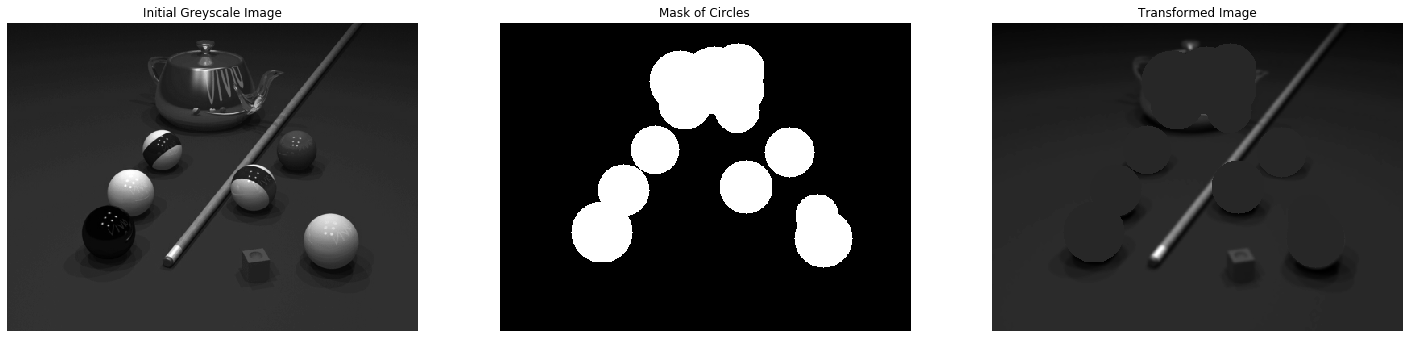

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import copy
from scipy import ndimage

# Read the images
img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')
img3 = cv2.imread('image3.png')

# converting bgr image to grayscale
grey =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
temp_grey = grey
# applying gaussian blur to remove noise and find "better" circles
grey = cv2.GaussianBlur(grey,(7,7),0)
# applying Hough transform for circles with tunned parameters
circles = cv2.HoughCircles(grey,cv2.HOUGH_GRADIENT,1,25,
                            param1=25,param2=17,minRadius=20,maxRadius=40)
# creating a mask from found circles with slightly bigger radius
black = np.zeros(grey.shape)
for x, y, r in circles[0]:
    cv2.circle(black, (x,y), int(r+5), 1, -1)  # -1 to draw filled circles

# Replacing the circles from the image, with the averagy color
mean = grey.mean()
grey[black == 1] = mean

fig, axes = plt.subplots(1, 3, figsize=(25,10))

plt.subplot(131), plt.imshow(temp_grey, cmap='gray'), plt.axis('off'), plt.title("Initial Greyscale Image")
plt.subplot(132), plt.imshow(black, cmap='gray'), plt.axis('off'), plt.title("Mask of Circles")
plt.subplot(133), plt.imshow(grey, cmap='gray'), plt.axis('off'), plt.title("Transformed Image")
plt.show()


\* Although a circle overlaps the billiard cue on the Transformed Image, it doesn't affect the result.

### Step two - finding edges
In this step we use a smoothing filter again to smoothen the edges of mean color circles that were added to the image. Next Canny edges are found and the image is rotated by 50.9 deg clockwise and a row is added to fit the image2's dimensions.

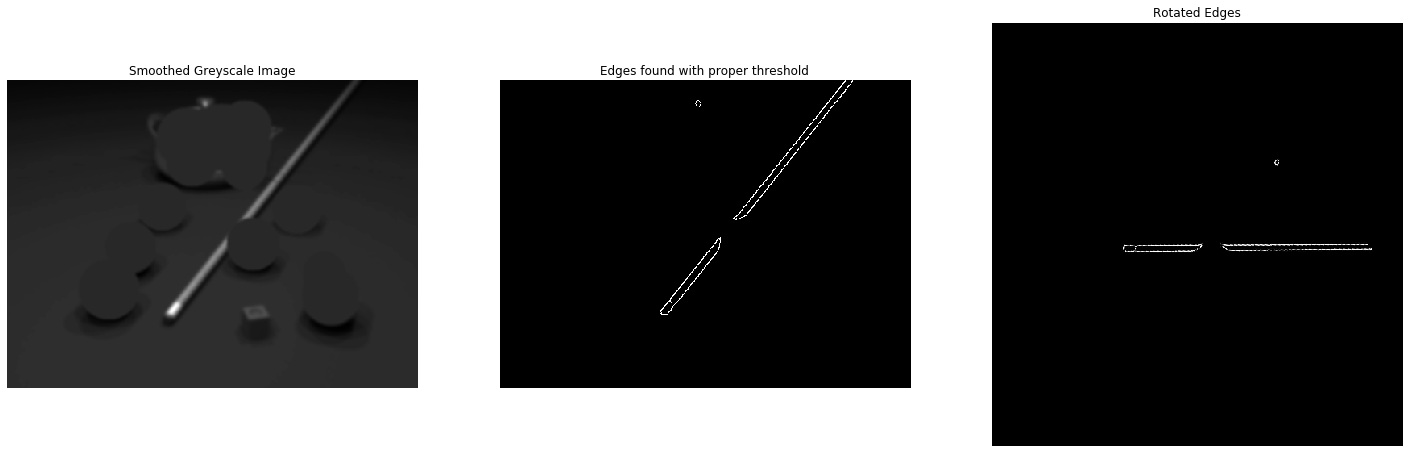

In [3]:
# smoothing the edges of the circles filled with average color
smoothed_grey = cv2.GaussianBlur(grey,(7,7),0)

# extracting the edges
edges190 = cv2.Canny(smoothed_grey,50,150,apertureSize = 3)
temp_edges = copy.copy(edges190)
# rotating the image
edges190 = ndimage.rotate(edges190, -50.9)
# adding one row to match image2 dimensions
x = np.zeros((1,edges190.shape[1]))
edges190 = np.row_stack((edges190, x)) 

fig, axes = plt.subplots(1, 3, figsize=(25,10))

plt.subplot(131), plt.imshow(smoothed_grey, cmap='gray'), plt.axis('off'), plt.title("Smoothed Greyscale Image")
plt.subplot(132), plt.imshow(temp_edges, cmap='gray'), plt.axis('off'), plt.title("Edges found with proper threshold")
plt.subplot(133), plt.imshow(edges190, cmap='gray'), plt.axis('off'), plt.title("Rotated Edges")
plt.show()

\* We can see here that there is a circular spot left above the needed object. It will be removed in the next step

### Step three - Erosion, Dilation Pipeline
In this step firstly the image is dilated to fill the gap between edges. Secondly it is eroded to remove the unwanted object above the billiard cue. Finally it is dilated again to regain the initial size. Now we have a mask extracted from image1, that is exactly on the billiard cue.

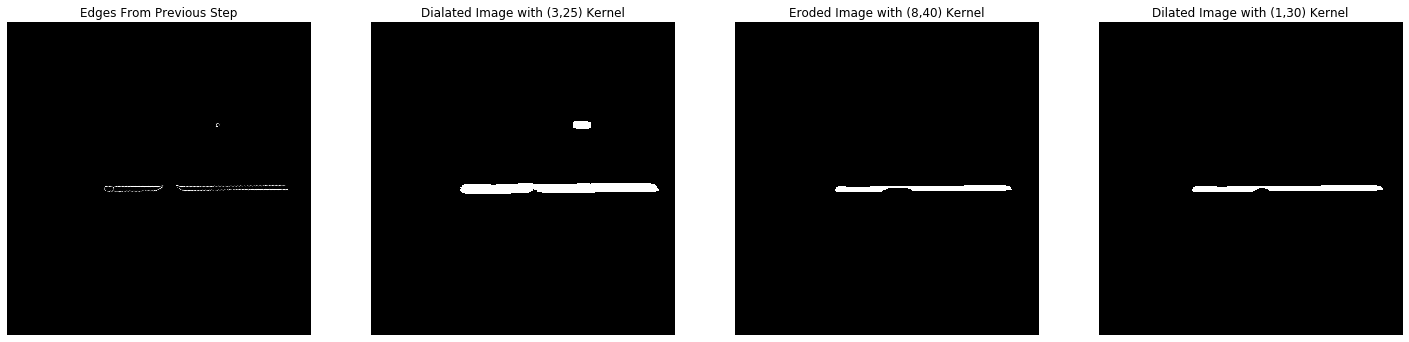

In [4]:
# Dilate to fill the edge gap
kernel = np.ones((3,25),np.uint8)
dilated = cv2.dilate(edges190,kernel,iterations = 1)

# Erode to remove unwanted object
kernel = np.ones((8,40),np.uint8)
ero = cv2.erode(dilated,kernel,iterations = 1)

# Dilate again to regain the initial size
kernel = np.ones((1,30),np.uint8)
final_mask = cv2.dilate(ero,kernel,iterations = 1)

fig, axes = plt.subplots(1, 4, figsize=(25,10))


plt.subplot(141), plt.imshow(edges190, cmap='gray'), plt.axis('off'), plt.title("Edges From Previous Step")
plt.subplot(142), plt.imshow(dilated<1, cmap='binary'), plt.axis('off'), plt.title("Dialated Image with (3,25) Kernel")
plt.subplot(143), plt.imshow(ero<1, cmap='binary'), plt.axis('off'), plt.title("Eroded Image with (8,40) Kernel")
plt.subplot(144), plt.imshow(final_mask<1, cmap='binary'), plt.axis('off'), plt.title("Dilated Image with (1,30) Kernel")
plt.show()

### Step 4 - Final Result
In this final step we apply the mask from the previous step on the image2, getting the asked result

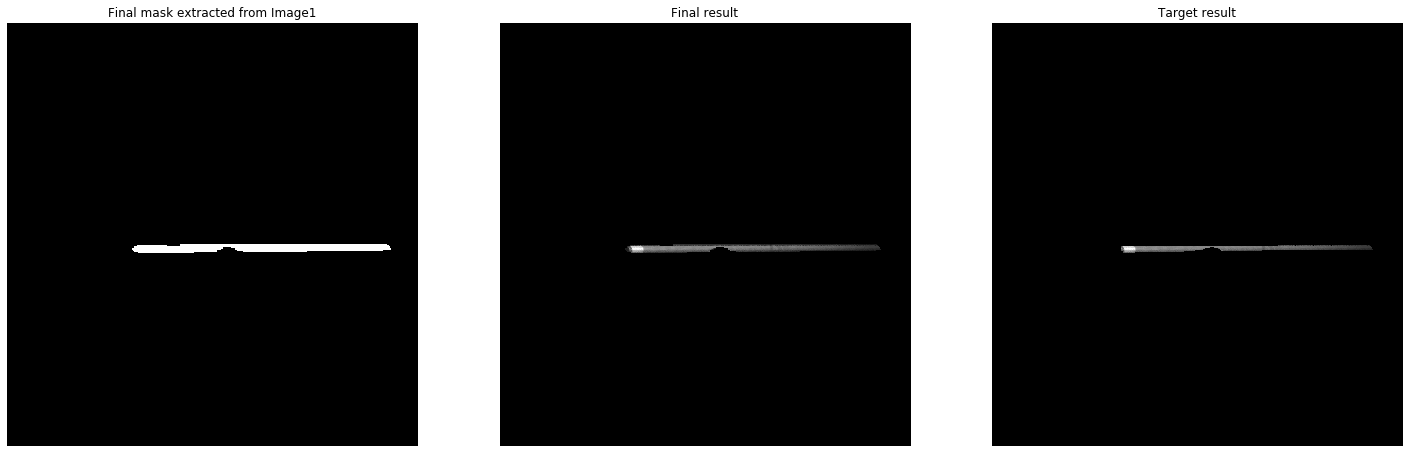

In [5]:
# Applying the mask extracted from image1 to image2 to get the final result
img2[final_mask == 0] = (0,0,0)

fig, axes = plt.subplots(1, 3, figsize=(25,10))

plt.subplot(131), plt.imshow(final_mask<1, cmap='binary'), plt.axis('off'), plt.title("Final mask extracted from Image1")
plt.subplot(132), plt.imshow(img2, cmap='gray'), plt.axis('off'), plt.title("Final result")
plt.subplot(133), plt.imshow(img3, cmap='gray'), plt.axis('off'), plt.title("Target result")
plt.show()

## All the steps combined in one

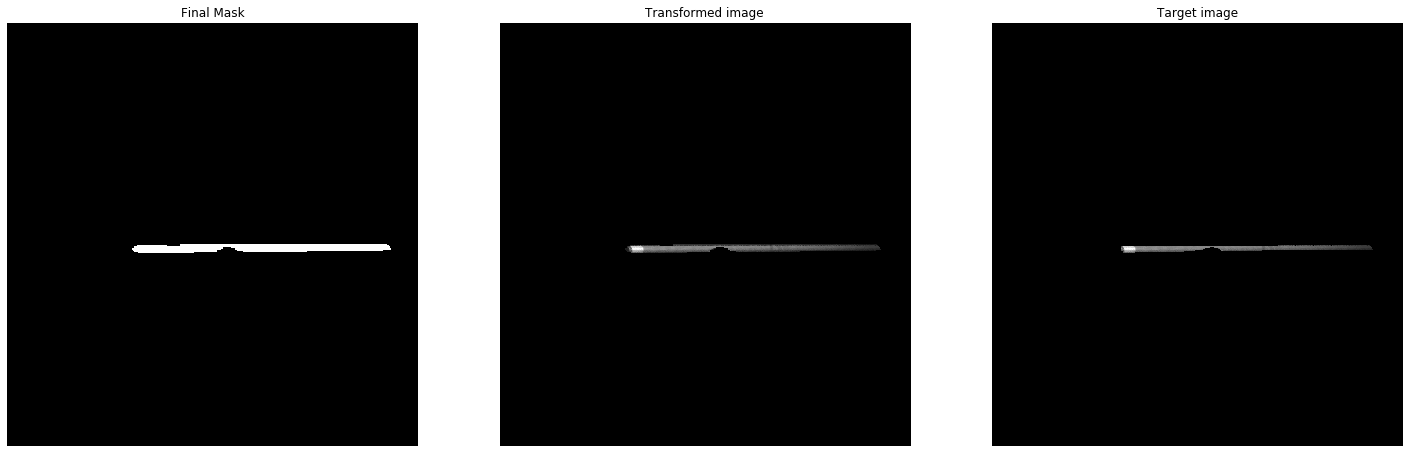

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import copy
from scipy import ndimage

# Read the images
img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')
img3 = cv2.imread('image3.png')

grey =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
grey = cv2.GaussianBlur(grey,(7,7),0)
circles = cv2.HoughCircles(grey,cv2.HOUGH_GRADIENT,1,25,
                            param1=25,param2=17,minRadius=20,maxRadius=40)
    
black = np.zeros(grey.shape)
for x, y, r in circles[0]:
    cv2.circle(black, (x,y), int(r+5), 1, -1)  # -1 to draw filled circles

mean = grey.mean()
grey[black == 1] = mean

grey = cv2.GaussianBlur(grey,(7,7),0)

edges190 = cv2.Canny(grey,50,150,apertureSize = 3)
edges190 = ndimage.rotate(edges190, -50.9)
x = np.zeros((1,edges190.shape[1]))
edges190 = np.row_stack((edges190, x)) 

kernel = np.ones((3,25),np.uint8)
dilated = cv2.dilate(edges190,kernel,iterations = 1)

kernel = np.ones((8,40),np.uint8)
ero = cv2.erode(dilated,kernel,iterations = 1)

kernel = np.ones((1,30),np.uint8)
final_mask = cv2.dilate(ero,kernel,iterations = 1)

img2[final_mask == 0] = (0,0,0)


cv2.imwrite("image.jpg",img2)

fig, axes = plt.subplots(1, 3, figsize=(25,10))


plt.subplot(131), plt.imshow(final_mask<1, cmap='binary'), plt.axis('off'), plt.title("Final Mask")
plt.subplot(132), plt.imshow(img2, cmap='gray'), plt.axis('off'), plt.title("Transformed image")
plt.subplot(133), plt.imshow(img3, cmap='gray'), plt.axis('off'), plt.title("Target image")
plt.show()

